In [1]:
import os
import sys
from pathlib import Path

# Dynamically locate project root and set working dir
project_root = Path().resolve().parents[1]
os.chdir(project_root)
sys.path.append(str(project_root))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from catboost import CatBoostRegressor, Pool
import optuna
from typing import Union, Dict, Tuple
from sklearn.model_selection import TimeSeriesSplit
from ydata_profiling import ProfileReport
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor as RF
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Table of Contents
- [Dataset Preparation](#Dataset-Preparation)
- [Baseline Model](#Baseline-Model)
- [Baseline Model with target lag features](#Baseline-Model-with-Target-Lag-Features)
- [Baseline Model with all lag features](#Baseline-Model-with-All-Lag-Features)
- [Gradient Boosting with Hyperparameters Tuning](#Gradient-Boosting-with-Hyperparameters-Tuning)
- [Conclusions](#Conclusions)

# Dataset Preparation

In [2]:
# Loading the data
data = pd.read_parquet('./data/raw_data/database.parquet')

In [3]:
data.head(3)

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


Let's drop the columns that are not required for further analysis and modeling.

- 'yr' does not seem to help because it
- 'casual', 'registered' are already included in the target column 'cnt'

In [4]:
drop_cols = ['yr', 'casual', 'registered', 'datetime']

In [5]:
data = data.drop(columns=drop_cols)

In [6]:
data.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32


# Baseline Model

We will use Random Forest using Raw Features as the Baseline Model because it does not require much tuning.

Then, we will add features and try other algorithms to see how big the improvement is.

For the metrics, we will use:
- MAPE
- MAE
- RMSE

In [7]:
def compute_metrics(
    y_true: Union[np.ndarray, list], # means: "The input can be either a NumPy array (np.ndarray) OR a Python list." 
    y_pred: Union[np.ndarray, list]
) -> Dict[str, float]:
    """
    Compute evaluation metrics between true and predicted values.

    Metrics returned:
    - MAPE: Mean Absolute Percentage Error (in %)
    - MAE: Mean Absolute Error
    - RMSE: Root Mean Squared Error

    Parameters:
    ----------
    y_true : array-like
        Ground truth values.
    y_pred : array-like
        Predicted values.

    Returns:
    -------
    dict
        Dictionary with keys 'MAPE', 'MAE', and 'RMSE' and their float values.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    y_true = np.array(y_true) #  This line converts whatever you gave (list or array) into a NumPy array so we can do math operations easily.
    y_pred = np.array(y_pred)

    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 0.01, y_true))) * 100

    """
    np.where(y_true == 0, 0.01, y_true)
    This is a trick to avoid dividing by zero.

    It says:

    If y_true is 0, replace it with 0.01 (a tiny number).
    Otherwise, keep the original value. 

    np.abs(...)
    Take absolute value — we care about size of error, not direction.
    [0.1, -0.2, -1000, 0.1] → [0.1, 0.2, 1000, 0.1]

    np.mean(...)
    Take the average of all percentage errors.
    
    np.mean([0.1, 0.2, 1000, 0.1]) ≈ 250.1
    
    *100
    to get percentage value
    
    """

    return {
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE': round(mape, 2)
    }

In [9]:
def prepare_dataset(
    df: pd.DataFrame, 
    train_fraction: float = 0.8
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Splits a DataFrame into training and testing sets for features and target.

    Parameters:
    ----------
    df : pd.DataFrame
        The input DataFrame that must contain a 'target' column.
    train_fraction : float, optional (default=0.8)
        The fraction of data to use for training (between 0 and 1).

    Returns:
    -------
    x_train : pd.DataFrame
        Training features.
    x_test : pd.DataFrame
        Testing features.
    y_train : pd.Series
        Training target values.
    y_test : pd.Series
        Testing target values.
    """
    feats = [col for col in df.columns if col != 'target']
    x, y = df[feats], df['target']
    train_size = int(train_fraction * df.shape[0])
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return x_train, x_test, y_train, y_test

#### Target definition

For the target, we will use the next hour bike count because we want to predict what this value will be ti adjust the pricing.

In [10]:
df = data.copy()

In [11]:
df['target'] = df['cnt'].shift(-1).fillna(method='ffill')
"""
"Based on what's happening right now (like time, weather, etc.), how many bikes will be rented in the next hour?" 

So:

At 1 PM, I want to predict how many bikes will be rented from 2–3 PM.
At 2 PM, I want to predict 3–4 PM, and so on.

This is forecasting the future.

So what does shift(-1) do?
Let’s apply it step by step.

Start with cnt:

1 PM:  15
2 PM:  30
3 PM:  20
4 PM:  40

Now do: df['cnt'].shift(-1)

This moves each value up by one row (i.e., earlier in time):

1 PM:  30   ← was originally at 2 PM
2 PM:  20   ← was originally at 3 PM
3 PM:  40   ← was originally at 4 PM
4 PM:  NaN  ← no data after 4 PM

Now assign this to target:

   HOUR      COUNT   TARGET  
1 PM - 2 PM    15     30
2 PM - 3 PM    30     20
3 PM - 4 PM    20     40
4 PM - 5 PM    40     NaN → will be filled to 40

Now interpret this:

At 1 PM, based on current data (15 rentals), we are training the model to predict 30 → which is the next hour's rentals (2–3 PM).
At 2 PM, predict 20 (3–4 PM), and so on.

So the model learns:

"Given the situation at time t, predict the bike count at time t+1." 

"""
df.drop(columns=['cnt'], inplace=True)

In [12]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction=0.8)

In [13]:
%%time
model = RF(n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

CPU times: total: 7.66 s
Wall time: 7.8 s


In [18]:
metrics_base = compute_metrics(y_test.values, y_pred)
metrics_base

{'MAE': 84.72, 'RMSE': 115.91, 'MAPE': 34.56}

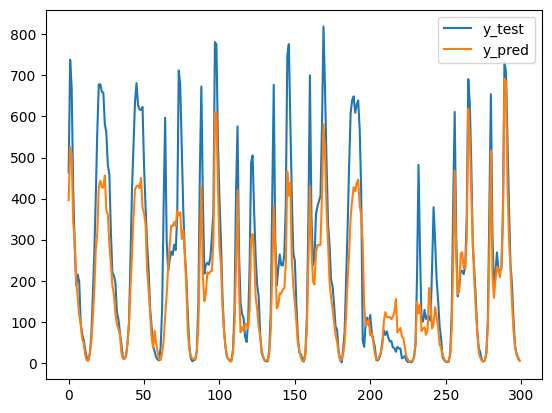

In [19]:
n = 300
plt.plot(y_test.values[:n], label='y_test')
plt.plot(y_pred[:n], label='y_pred')
plt.legend()
plt.show()

**Observations**

- We see that values below 200 are well predicted
- We see that the peaks are significantly underpredicted.

**Dummy model**

A dummy model is the model that tells that the next target value is the same as the previous value.

In [20]:
y_dummy = y_test.shift(1).fillna(method='bfill')
# we have justt changed forward fill(ffill) to backword fill(bfill) and we shift it to 1 ahead here first row will get NaN
metrics_dummy = compute_metrics(y_test.values, y_dummy)

In [21]:
print('Dummy model scores:', metrics_dummy)
print('Baseline model scores:', metrics_base)

Dummy model scores: {'MAE': 87.01, 'RMSE': 128.17, 'MAPE': 55.4}
Baseline model scores: {'MAE': 84.72, 'RMSE': 115.91, 'MAPE': 34.56}


We see that our Baseline Model does not do much better that the dummy model

We see that only the MAPE metrics decreased quite well, while the other two are not, especially MAE.

This gives the conclusion that some feature engineering is definteily required.

# Baseline Model with Target Lag Features

A good idea is to add the lagged values of the target because we assume it's goona be available by the time we make the predictions for the next hour.

To understand how many lagged features we need, let's compute autocorrelation for the target.

***In Short:***

**Lag Features:** Past values of the target used as inputs (e.g.,target.shift(1)). Captures temporal dependencies.

**Autocorrelation:** Measures how strongly a variable correlates with its past values. Guides feature engineering.

In [20]:
# Let's compute autocorrelation
for lag in range(1, 25):
    print(f"Lag {lag}: {df['target'].autocorr(lag=lag):.3f}")

Lag 1: 0.845
Lag 2: 0.597
Lag 3: 0.407
Lag 4: 0.274
Lag 5: 0.146
Lag 6: 0.010
Lag 7: -0.094
Lag 8: -0.114
Lag 9: -0.058
Lag 10: -0.049
Lag 11: -0.100
Lag 12: -0.131
Lag 13: -0.105
Lag 14: -0.057
Lag 15: -0.058
Lag 16: -0.094
Lag 17: -0.065
Lag 18: 0.033
Lag 19: 0.153
Lag 20: 0.262
Lag 21: 0.371
Lag 22: 0.520
Lag 23: 0.705
Lag 24: 0.809


We see that the autocrrelations are high for the first and last 3 values that indicates a strong daily seasonality.

Let's add this lags.

When the model to be run in production, from the pipeline perspective, it's better to have the 'cnt' column back and take the lags relative to it to avoid confusion.

In [22]:
df = data.copy()
df['target'] = df['cnt'].shift(-1).fillna(method='ffill')
df.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,target
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,40.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,32.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,13.0


The 'cnt' column is alread 1 lag behind the target, so we need to make shifts of the 'cnt' column from 1 to 2 and from 22 to 23.

In [23]:
# Add first 2 lags
for i in range(1, 3):
    df[f'cnt_lag_{i}'] = df['cnt'].shift(i).fillna(method='bfill')

# Add last 2 lags
for i in range(22, 24):
    df[f'cnt_lag_{i}'] = df['cnt'].shift(i).fillna(method='bfill')

In [24]:
df.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,target,cnt_lag_1,cnt_lag_2,cnt_lag_22,cnt_lag_23
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,40.0,16.0,16.0,16.0,16.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,32.0,16.0,16.0,16.0,16.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,13.0,40.0,16.0,16.0,16.0


Let's see if this helps the model

In [30]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction=0.8)

In [31]:
x_train

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,cnt_lag_1,cnt_lag_2,cnt_lag_22,cnt_lag_23
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16,16.0,16.0,16.0,16.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40,16.0,16.0,16.0,16.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32,40.0,16.0,16.0,16.0
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13,32.0,40.0,16.0,16.0
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1,13.0,32.0,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11117,2,4,10,0,5,1,1,0.44,0.4394,0.38,0.1940,192,330.0,563.0,259.0,224.0
11118,2,4,11,0,5,1,1,0.46,0.4545,0.36,0.1343,233,192.0,330.0,203.0,259.0
11119,2,4,12,0,5,1,1,0.50,0.4848,0.31,0.0000,322,233.0,192.0,224.0,203.0
11120,2,4,13,0,5,1,1,0.52,0.5000,0.27,0.2836,358,322.0,233.0,211.0,224.0


In [32]:
model = RF(n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [33]:
metrics_target_lag = compute_metrics(y_test.values, y_pred)
metrics_target_lag

{'MAE': 42.98, 'RMSE': 70.43, 'MAPE': 24.5}

In [34]:
print('Baseline model scores:', metrics_base)
print('Baseline model with target lags scores:', metrics_target_lag)

Baseline model scores: {'MAE': 84.72, 'RMSE': 115.91, 'MAPE': 34.56}
Baseline model with target lags scores: {'MAE': 42.98, 'RMSE': 70.43, 'MAPE': 24.5}


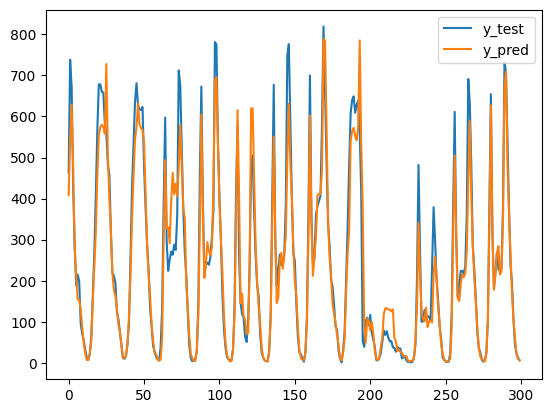

In [35]:
n = 300
plt.plot(y_test.values[:n], label='y_test')
plt.plot(y_pred[:n], label='y_pred')
plt.legend()

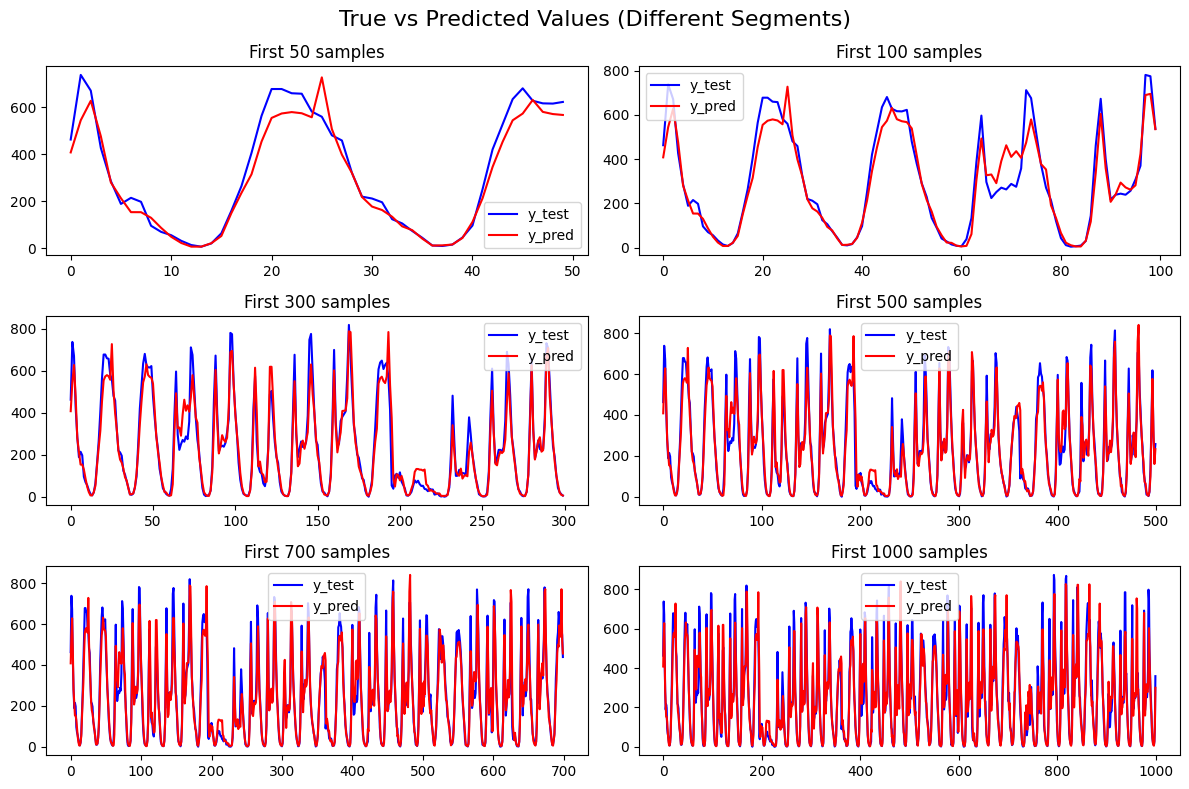

In [40]:
# Define the segments (different n values)
segments = [50, 100, 300, 500, 700, 1000]

# Create a 3x2 subplot layout
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('True vs Predicted Values (Different Segments)', fontsize=16)

# Flatten axes for easy looping
axes = axes.flatten()

# Loop over each segment
for i, n in enumerate(segments):
    ax = axes[i]
    ax.plot(y_test.values[:n], label='y_test', color='blue')
    ax.plot(y_pred[:n], label='y_pred', color='red')
    ax.set_title(f'First {n} samples')
    ax.legend()

# Make layout tight so plots don't overlap
plt.tight_layout()
plt.show()

Now we see a significant imporvement.

We clearly see that the peaks now are better captured.

# Baseline Model with All Lag Features

Let's add the lag features for other features, not only for the target.

We will add only the first 3 lags, you can experiment with different lags and see the performance

#### Can you add lag features for other features?

Yes! but only for features that:

- "Change slowly over time and might influence the future." 

##### Not all features should have lags. Let’s see which ones should and which ones shouldn’t.

🔍 Rule: When to Create Lag Features?

✅ DO create lag features for:
Features that:

- Change over time
- Have a delayed effect on the target
- Show patterns across time (like trends or cycles)


In [41]:
df.columns

Index(['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'target',
       'cnt_lag_1', 'cnt_lag_2', 'cnt_lag_22', 'cnt_lag_23'],
      dtype='object')

In [42]:
lag_feats = ['hr', 'weekday', 'weathersit', 'temp', 'hum']

n = 3
for feat in lag_feats:
    for i in range(1, n+1):
        df[f'{feat}_lag_{i}'] = df[feat].shift(i).fillna(method='bfill')

In [43]:
df.columns

Index(['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'target',
       'cnt_lag_1', 'cnt_lag_2', 'cnt_lag_22', 'cnt_lag_23', 'hr_lag_1',
       'hr_lag_2', 'hr_lag_3', 'weekday_lag_1', 'weekday_lag_2',
       'weekday_lag_3', 'weathersit_lag_1', 'weathersit_lag_2',
       'weathersit_lag_3', 'temp_lag_1', 'temp_lag_2', 'temp_lag_3',
       'hum_lag_1', 'hum_lag_2', 'hum_lag_3'],
      dtype='object')

In [44]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction=0.8)

In [45]:
x_train.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,weekday_lag_3,weathersit_lag_1,weathersit_lag_2,weathersit_lag_3,temp_lag_1,temp_lag_2,temp_lag_3,hum_lag_1,hum_lag_2,hum_lag_3
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.22,0.24,0.24,0.80,0.81,0.81


In [46]:
x_train.columns

Index(['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'cnt_lag_1',
       'cnt_lag_2', 'cnt_lag_22', 'cnt_lag_23', 'hr_lag_1', 'hr_lag_2',
       'hr_lag_3', 'weekday_lag_1', 'weekday_lag_2', 'weekday_lag_3',
       'weathersit_lag_1', 'weathersit_lag_2', 'weathersit_lag_3',
       'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'hum_lag_1', 'hum_lag_2',
       'hum_lag_3'],
      dtype='object')

In [47]:
%%time
np.random.seed(23)
model = RF(n_estimators=100, verbose=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   14.5s


CPU times: total: 27.3 s
Wall time: 28.3 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   27.9s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [48]:
metrics_all_lags = compute_metrics(y_test.values, y_pred)
metrics_all_lags

{'MAE': 43.42, 'RMSE': 71.27, 'MAPE': 24.19}

In [49]:
print('Baseline model scores:', metrics_base)
print('Baseline model with target lags scores:', metrics_target_lag)
print('Baseline model with all lags scores:', metrics_all_lags)

Baseline model scores: {'MAE': 84.72, 'RMSE': 115.91, 'MAPE': 34.56}
Baseline model with target lags scores: {'MAE': 42.98, 'RMSE': 70.43, 'MAPE': 24.5}
Baseline model with all lags scores: {'MAE': 43.42, 'RMSE': 71.27, 'MAPE': 24.19}


We see that adding the feature lags futher improved the performance, but the improvement is not that big as before.

However, with some basic feature engineering we still able to improve the scores and this we can add to the final production pipeline.

## Training with RNN using PyTorch

# Gradient Boosting with Hyperparameters Tuning

In [50]:
df.reset_index(drop=True, inplace=True)

In [51]:
df

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,weekday_lag_3,weathersit_lag_1,weathersit_lag_2,weathersit_lag_3,temp_lag_1,temp_lag_2,temp_lag_3,hum_lag_1,hum_lag_2,hum_lag_3
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.22,0.24,0.24,0.80,0.81,0.81
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.22,0.22,0.24,0.80,0.80,0.81
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.24,0.22,0.22,0.75,0.80,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13898,3,8,7,0,2,1,2,0.70,0.6667,0.74,...,2.0,2.0,1.0,1.0,0.70,0.70,0.68,0.79,0.79,0.83
13899,3,8,8,0,2,1,2,0.70,0.6515,0.70,...,2.0,2.0,2.0,1.0,0.70,0.70,0.70,0.74,0.79,0.79
13900,3,8,9,0,2,1,2,0.70,0.6667,0.74,...,2.0,2.0,2.0,2.0,0.70,0.70,0.70,0.70,0.74,0.79
13901,3,8,10,0,2,1,2,0.74,0.6970,0.70,...,2.0,2.0,2.0,2.0,0.70,0.70,0.70,0.74,0.70,0.74


In [52]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction=0.8)

In [53]:
x_train

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,weekday_lag_3,weathersit_lag_1,weathersit_lag_2,weathersit_lag_3,temp_lag_1,temp_lag_2,temp_lag_3,hum_lag_1,hum_lag_2,hum_lag_3
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.22,0.24,0.24,0.80,0.81,0.81
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.22,0.22,0.24,0.80,0.80,0.81
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.24,0.22,0.22,0.75,0.80,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11117,2,4,10,0,5,1,1,0.44,0.4394,0.38,...,5.0,1.0,1.0,1.0,0.42,0.38,0.34,0.41,0.46,0.61
11118,2,4,11,0,5,1,1,0.46,0.4545,0.36,...,5.0,1.0,1.0,1.0,0.44,0.42,0.38,0.38,0.41,0.46
11119,2,4,12,0,5,1,1,0.50,0.4848,0.31,...,5.0,1.0,1.0,1.0,0.46,0.44,0.42,0.36,0.38,0.41
11120,2,4,13,0,5,1,1,0.52,0.5000,0.27,...,5.0,1.0,1.0,1.0,0.50,0.46,0.44,0.31,0.36,0.38


In [57]:
# Step 1: Define the Optuna objective with TimeSeriesSplit on x_train
def objective(trial):
    np.random.seed(42)
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "depth": trial.suggest_int("depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.5, 5),
        "iterations": 1000,
        "loss_function": "RMSE",
        "verbose": 0
    }

    train_idx = int(0.85 * x_train.shape[0])

    x_tr, x_val = x_train.iloc[:train_idx], x_train.iloc[train_idx:]
    y_tr, y_val = y_train.iloc[:train_idx], y_train.iloc[train_idx:]

    model = CatBoostRegressor(**params, random_seed=42)
    model.fit(x_tr, y_tr,
              eval_set=(x_val, y_val),
              early_stopping_rounds=100,
              use_best_model=True)

    preds = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))

    # Save best iteration
    trial.set_user_attr("best_iteration", model.get_best_iteration())

    return rmse

What is Cross-Validation (CV)?

It means:

"Split the data into 5 parts → train on 4, validate on 1 → repeat 5 times → average results." 

This gives a more reliable estimate of performance.

❌ Why didn’t we use it here?

Because:

Time: CV is slower — it trains the model 5x more.
Time series data: Standard CV shuffles data → breaks time order → leaks future data → invalid.

🚫 You cannot randomly shuffle time series data! 

✅ Better option: TimeSeriesSplit

For time series, we should use:

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

What do these parameters do inside model.fit()?
model.fit(
    x_tr, y_tr,
    eval_set=(x_val, y_val),
    early_stopping_rounds=100,
    use_best_model=True
)

Let’s break it down line by line.

📥 x_tr, y_tr

Training data: model learns from this.

🎯 eval_set=(x_val, y_val)

Validation set: used to check performance during training.

The model does NOT learn from this — it’s only for monitoring.

Helps detect overfitting (when model gets worse on validation).

⏳ early_stopping_rounds=100

"If the model doesn’t improve on validation for 100 rounds, stop training." 

Example:

RMSE keeps going down → keep training
RMSE stops improving for 100 trees → stop early

✅ Saves time
✅ Prevents overfitting

✅ use_best_model=True

"Don’t use the final model — use the one that did best on validation." 

Even if training continues, the model remembers the best version.

💡 Like: "I peaked at step 432 — use that version, not my tired final self."

What is trial.set_user_attr("best_iteration", model.get_best_iteration())?
After training:

trial.set_user_attr("best_iteration", model.get_best_iteration())

🔍 What is model.get_best_iteration()?

Returns the tree number where the model performed best on validation.

Example: 432 → best prediction happened at tree #432.

📌 What does trial.set_user_attr(...) do?

Saves extra info from this trial so we can use it later.
Here: save best_iteration for each trial.

Why? So later we can:

"Now that I know the best settings, I’ll train the final model using the best number of trees." 

In [58]:
# Step 2: Run the Optuna study
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=150)

# Step 4: Train final model on full x_train with best parameters
best_params = study.best_trial.params

[I 2025-08-08 22:20:58,617] A new study created in memory with name: no-name-f07c91ef-fabe-4474-a820-ad8c986d9783
[I 2025-08-08 22:21:02,930] Trial 0 finished with value: 62.631936201851325 and parameters: {'learning_rate': 0.08116262258099886, 'depth': 8, 'l2_leaf_reg': 3.793972738151323}. Best is trial 0 with value: 62.631936201851325.
[I 2025-08-08 22:21:03,979] Trial 1 finished with value: 60.80780968109356 and parameters: {'learning_rate': 0.12374511199743694, 'depth': 3, 'l2_leaf_reg': 1.201975341512912}. Best is trial 1 with value: 60.80780968109356.
[I 2025-08-08 22:21:13,235] Trial 2 finished with value: 61.810606852953356 and parameters: {'learning_rate': 0.021035886311957897, 'depth': 8, 'l2_leaf_reg': 3.20501755284444}. Best is trial 1 with value: 60.80780968109356.
[I 2025-08-08 22:21:14,234] Trial 3 finished with value: 61.2588653634944 and parameters: {'learning_rate': 0.14453378978124864, 'depth': 3, 'l2_leaf_reg': 4.864594334728975}. Best is trial 1 with value: 60.8078

In [60]:
best_trial = study.best_trial
print("Best RMSE:", best_trial.value)
print("Best iteration (trees):", best_trial.user_attrs["best_iteration"])

Best RMSE: 56.92569050185653
Best iteration (trees): 88


In [61]:
best_params.update({
    "iterations": best_trial.user_attrs["best_iteration"],
    "loss_function": "RMSE",
    "verbose": 0
})

What is this code?

best_params.update({
    "iterations": best_trial.user_attrs["best_iteration"],
    "loss_function": "RMSE",
    "verbose": 0
})

Let’s say Optuna found the best trial:

best_trial = study.best_trial

Now we want to build the final model with the best settings.

But remember:

During tuning, we used iterations=1000 (fixed)
But the model stopped early at tree #432
That means: training longer didn’t help

So instead of using 1000 trees, we update:

"iterations": best_trial.user_attrs["best_iteration"]

👉 Set iterations = 432 (the best point)

Then:

"loss_function": "RMSE",   # needed for final model
"verbose": 0               # stay quiet

And update the params:

best_params.update({...})

👉 Adds these values to the best settings.

Now you can train your final model efficiently:

final_model = CatBoostRegressor(**best_params)
final_model.fit(x_train, y_train)  # no validation needed now

✅ Uses the best settings
✅ Uses the best number of trees
✅ No wasted training

In [62]:
final_model = CatBoostRegressor(**best_params)
final_model.fit(x_train, y_train)

# Step 5: Predict on x_test and evaluate
y_pred = final_model.predict(x_test)
metrics_catbost = compute_metrics(y_test.values, y_pred)
metrics_catbost

{'MAE': 41.19, 'RMSE': 64.82, 'MAPE': 26.62}

**✅ Summary Table**

- ❓ Why no cross-validation? - We used a simple split. For time series, use TimeSeriesSplit, not regular CV.

- ⏳early_stopping_rounds=100 - Stop if no improvement in 100 steps ✅

- use_best_model=True - Use best version, not final 📌

- set_user_attr - save best iteration for later 🔙

- best_params.update(...) - Set final model to use best number of trees

In [63]:
print('Baseline model scores:', metrics_base)
print('Baseline model with target lags scores:', metrics_target_lag)
print('Baseline model with all lags scores:', metrics_all_lags)
print('Tuned Catboost:', metrics_catbost)

Baseline model scores: {'MAE': 84.72, 'RMSE': 115.91, 'MAPE': 34.56}
Baseline model with target lags scores: {'MAE': 42.98, 'RMSE': 70.43, 'MAPE': 24.5}
Baseline model with all lags scores: {'MAE': 43.42, 'RMSE': 71.27, 'MAPE': 24.19}
Tuned Catboost: {'MAE': 41.19, 'RMSE': 64.82, 'MAPE': 26.62}


In [64]:
best_params

{'learning_rate': 0.14805627256213708,
 'depth': 6,
 'l2_leaf_reg': 0.636825042901449,
 'iterations': 88,
 'loss_function': 'RMSE',
 'verbose': 0}

# 🧪 Optuna: Dynamic Search Spaces Hyperparameter Tuning for Time Series Regression

training **6 regression models** using Optuna:
- CatBoost
- XGBoost
- LightGBM
- RandomForest
- Gradient Boosting
- AdaBoost

Uses **TimeSeriesSplit** for correct validation on time series data.  
Returns **RMSE** (lower = better).  
Picks the **best model + best settings** automatically.

In [4]:
# !pip install xgboost

   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Acer\.conda\envs\ml-blueprint\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\Acer\.conda\envs\ml-blueprint\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\.conda\envs\ml-blueprint\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\.conda\envs\ml-blueprint\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\.conda\envs\ml-blueprint\Lib\http\client.py", line 473, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\.conda\envs\ml-blueprint\L

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import optuna
import numpy as np

# Use TimeSeriesSplit for correct time-series validation
tscv = TimeSeriesSplit(n_splits=3)

# Define the objective function
def objective(trial):
    # Suggest which model to use
    model_name = trial.suggest_categorical('model', [
        'CatBoost', 'XGBoost', 'LightGBM', 'RandomForest', 
        'GradientBoosting', 'AdaBoost'
    ])

    # To store model and handle GPU/parallel settings
    model = None

    if model_name == 'CatBoost':
        params = {
            'learning_rate': trial.suggest_float('cat_lr', 0.01, 0.2),
            'depth': trial.suggest_int('cat_depth', 3, 10),
            'l2_leaf_reg': trial.suggest_float('cat_l2', 1.0, 5.0),
            'iterations': 1000,
            'loss_function': 'RMSE',
            'verbose': False,
            'random_seed': 42,
            'task_type': 'CPU'  # Change to 'GPU' if you have GPU support
        }
        from catboost import CatBoostRegressor
        model = CatBoostRegressor(**params)
        fit_params = {'eval_set': [(X_train, y_train)], 'early_stopping_rounds': 100}

    elif model_name == 'XGBoost':
        params = {
            'learning_rate': trial.suggest_float('xgb_lr', 0.01, 0.3),
            'max_depth': trial.suggest_int('xgb_depth', 3, 10),
            'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('xgb_colsample', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('xgb_alpha', 0.01, 10.0, log=True),
            'reg_lambda': trial.suggest_float('xgb_lambda', 0.01, 10.0, log=True),
            'n_estimators': 1000,
            'objective': 'reg:squarederror',
            'random_state': 42,
            'n_jobs': -1,  # Use all CPU cores
            # 'tree_method': 'gpu_hist'  # Uncomment if you have GPU
        }
        from xgboost import XGBRegressor
        model = XGBRegressor(**params)
        fit_params = {'eval_set': [(X_train, y_train)], 'early_stopping_rounds': 100, 'verbose': False}

    elif model_name == 'LightGBM':
        params = {
            'learning_rate': trial.suggest_float('lgb_lr', 0.01, 0.2),
            'num_leaves': trial.suggest_int('lgb_leaves', 20, 200),
            'min_child_samples': trial.suggest_int('lgb_min_child', 5, 100),
            'feature_fraction': trial.suggest_float('lgb_feature_frac', 0.5, 1.0),
            'bagging_fraction': trial.suggest_float('lgb_bagging_frac', 0.5, 1.0),
            'bagging_freq': 5,
            'n_estimators': 1000,
            'objective': 'regression',
            'metric': 'rmse',
            'random_state': 42,
            'n_jobs': -1,
            # 'device': 'gpu'  # Uncomment if you have GPU
        }
        from lightgbm import LGBMRegressor
        model = LGBMRegressor(**params)
        fit_params = {'eval_set': [(X_train, y_train)], 'early_stopping_rounds': 100, 'verbose': False}

    elif model_name == 'RandomForest':
        params = {
            'n_estimators': trial.suggest_int('rf_n_estimators', 100, 500),
            'max_depth': trial.suggest_int('rf_max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('rf_min_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('rf_min_leaf', 1, 10),
            'max_features': trial.suggest_categorical('rf_max_features', ['sqrt', 'log2']),
            'bootstrap': True,
            'n_jobs': -1,  # Use all CPU cores
            'random_state': 42
        }
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(**params)
        fit_params = {}

    elif model_name == 'GradientBoosting':
        params = {
            'n_estimators': trial.suggest_int('gb_n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('gb_lr', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('gb_depth', 3, 10),
            'min_samples_split': trial.suggest_int('gb_min_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('gb_min_leaf', 1, 10),
            'subsample': trial.suggest_float('gb_subsample', 0.8, 1.0),
            'random_state': 42
        }
        from sklearn.ensemble import GradientBoostingRegressor
        model = GradientBoostingRegressor(**params)
        fit_params = {}

    elif model_name == 'AdaBoost':
        params = {
            'n_estimators': trial.suggest_int('ada_n_estimators', 50, 300),
            'learning_rate': trial.suggest_float('ada_lr', 0.01, 1.0, log=True),
            'random_state': 42
        }
        from sklearn.ensemble import AdaBoostRegressor
        model = AdaBoostRegressor(**params)
        fit_params = {}

    # Cross-validate using TimeSeriesSplit
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        if model_name in ['CatBoost', 'XGBoost', 'LightGBM']:
            model.fit(X_tr, y_tr, **fit_params)
        else:
            model.fit(X_tr, y_tr)

        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(rmse)

    # Return mean RMSE (lower = better)
    return np.mean(scores)

In [65]:
# Save the model to experiments
final_model.save_model('./models/experiments/final_catboost_model.cbm')

- We see that we are able to reduce the RMSE score and MAE score quite well.
- MAPE score has not been reduced. However, since we have quite many values close to zero, MAPE is not a good metric in this case.
- Note that in Bayesian Optiization we optimized for RMSE, we can also try to optimize for MAE.

# Conclusions

- The Baseline Random Foreset model with no feature engineering gave almost the same result as the dummy model (last value shifted forward)
- Adding the target lags and feature lags improved the model significantly,
- Changing Random Forest to Catboost and tuning Catboost Hyperparameters with Bayesian Optimization helped futher improve the scores.
- For the production pipeline, we will use Catboost Model with Hyperparameter tuning.